# Import the Dataset and inspect it

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df=pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv')
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [55]:
df.shape

(2900, 8)

In [56]:
df.isna().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

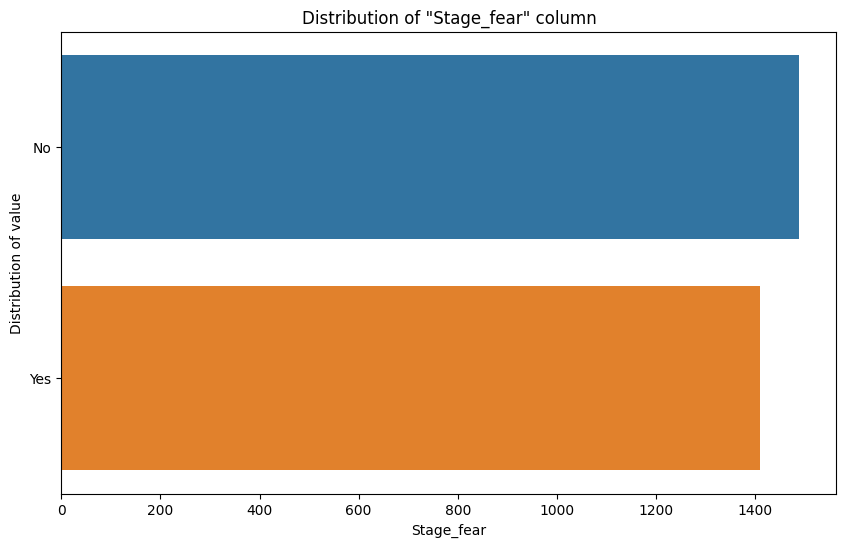

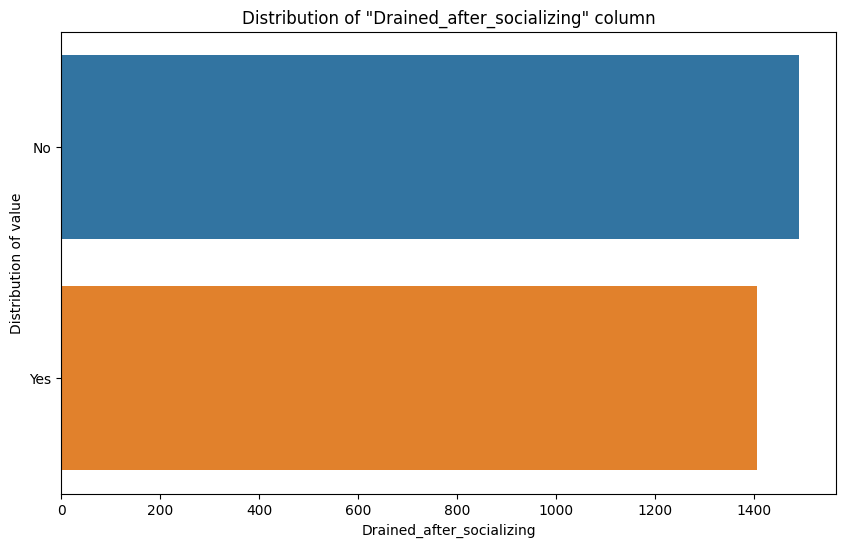

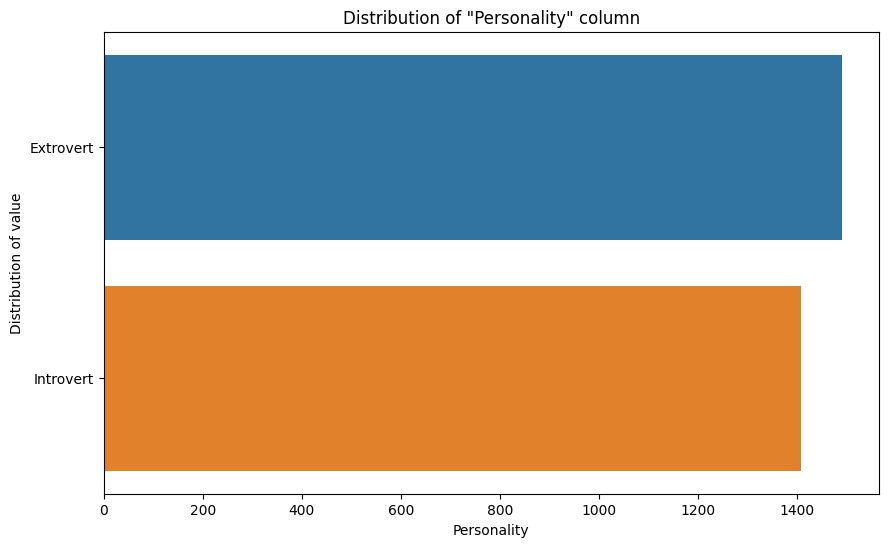

In [57]:
for column in df.columns:
    if df[column].dtypes=='object':
        plt.figure(figsize=(10,6))
        sns.countplot(data=df, y=column, order=df[column].value_counts().index)
        plt.title(f'Distribution of "{column}" column')
        plt.xlabel(f'{column}')
        plt.ylabel('Distribution of value')
        plt.show()

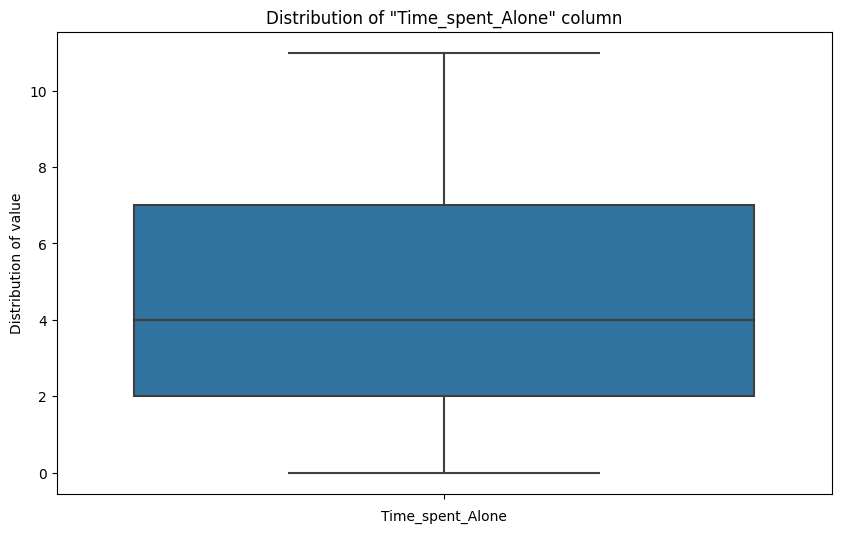

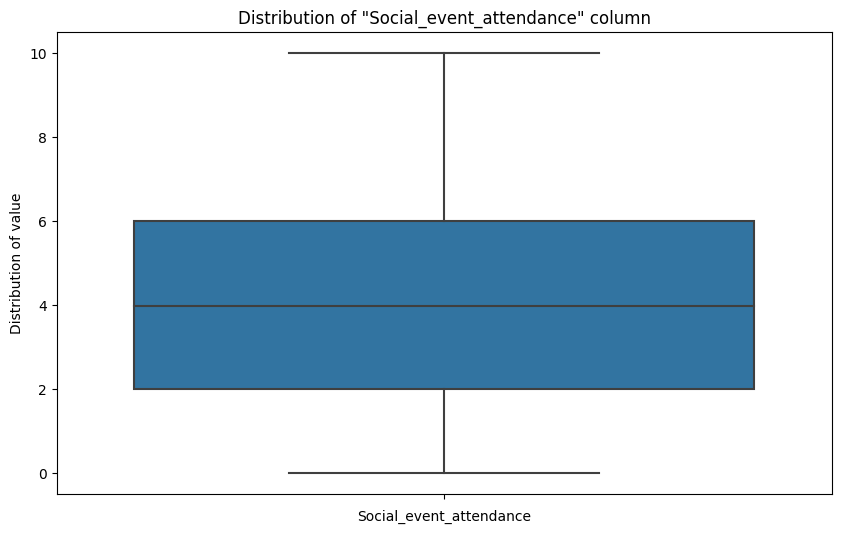

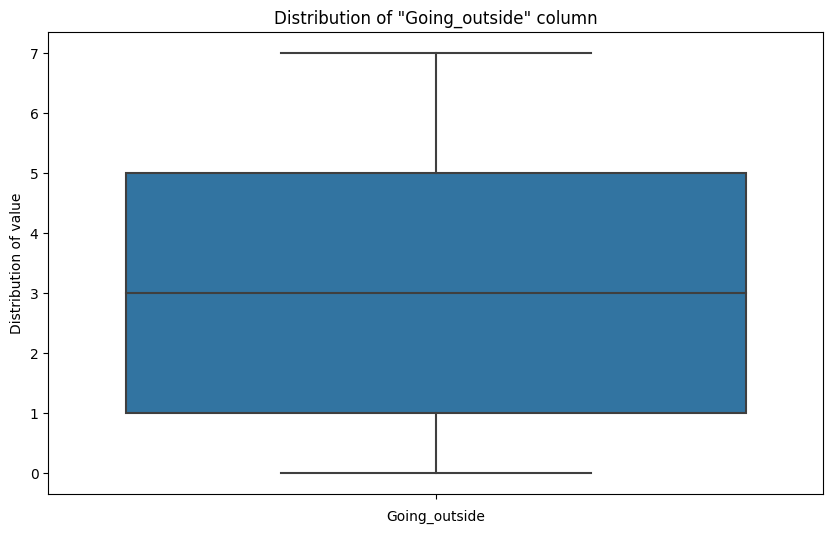

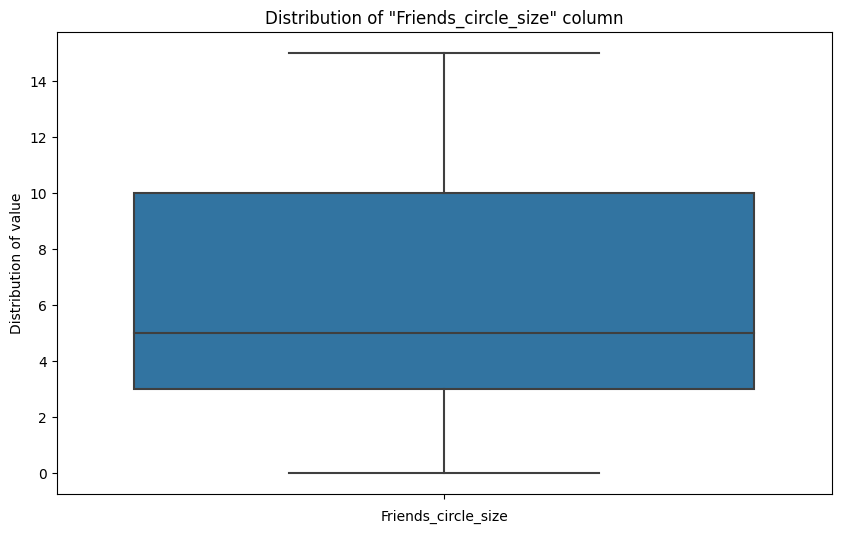

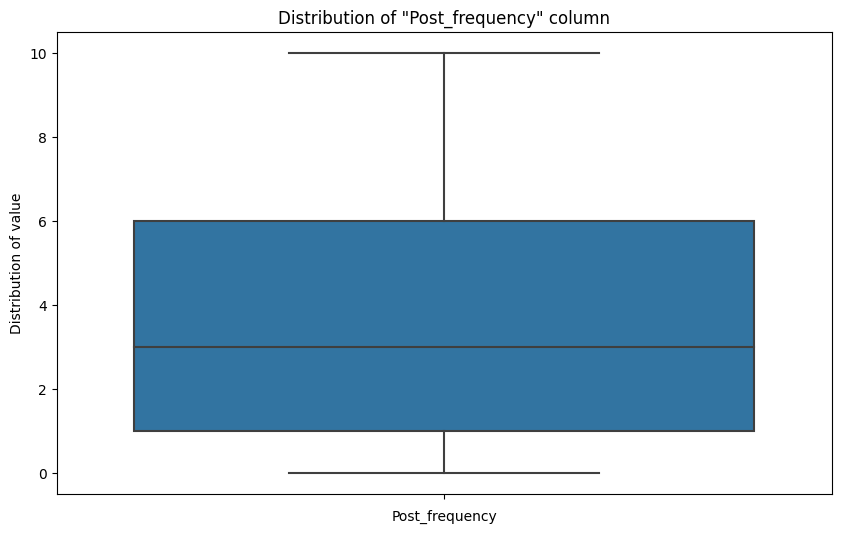

In [58]:
for column in df.columns:
    if df[column].dtypes != 'object':
        plt.figure(figsize=(10,6))
        sns.boxplot(data=df, y=column)
        plt.title(f'Distribution of "{column}" column')
        plt.xlabel(f'{column}')
        plt.ylabel('Distribution of value')
        plt.show()

## Fill the NULL values in the columns

In [59]:
obj_cols=[col for col in df.columns if df[col].dtypes=='object']
int_cols=[col for col in df.columns if df[col].dtypes!='object']

In [60]:
def show_null(dataframe, column_list):
    for col in column_list:
        print(f'Null value count for "{col}":{dataframe[col].isna().sum()}')
        print('-'*20)

In [61]:
show_null(df, obj_cols)

Null value count for "Stage_fear":0
--------------------
Null value count for "Drained_after_socializing":0
--------------------
Null value count for "Personality":0
--------------------


In [62]:
show_null(df,int_cols)

Null value count for "Time_spent_Alone":0
--------------------
Null value count for "Social_event_attendance":0
--------------------
Null value count for "Going_outside":0
--------------------
Null value count for "Friends_circle_size":0
--------------------
Null value count for "Post_frequency":0
--------------------


In [63]:
for col in int_cols:
    mean_value= df[col].mean()
    df.fillna({col: mean_value}, inplace=True)

show_null(df,int_cols)

Null value count for "Time_spent_Alone":0
--------------------
Null value count for "Social_event_attendance":0
--------------------
Null value count for "Going_outside":0
--------------------
Null value count for "Friends_circle_size":0
--------------------
Null value count for "Post_frequency":0
--------------------


In [64]:
for col in obj_cols:
    replace_value= 'NAV'
    df.fillna({col: replace_value}, inplace=True)

show_null(df,obj_cols)

Null value count for "Stage_fear":0
--------------------
Null value count for "Drained_after_socializing":0
--------------------
Null value count for "Personality":0
--------------------


In [65]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.441180,2.872608,2.221597,4.232340,2.893587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.963354,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


## Getting the correlation matrix

### 1. column type: object_categorical vs object_categorical (theil's U)

In [66]:
from collections import Counter

def entropy(series):
    probs= pd.Series(Counter(series)).astype('float') / len(series)
    return -np.sum(probs * np.log2(probs+0.0000001))

def conditional_entropy(x,y):
    res=0.0
    y_ser= pd.Series(y)
    uni_y=y_ser.unique()

    for value in uni_y:
        subset= x[y_ser==value]
        weight= len(subset)/ len(x)
        res += weight * entropy(subset)

    return res


def uncertainty_coef(x,y):
    x=pd.Series(x)
    y=pd.Series(y)
    e_x= entropy(x)

    if e_x == 0.0:
        return 1.0

    e_x_given_y = conditional_entropy(x,y)
    u= (e_x- e_x_given_y)/ e_x
    return u

In [67]:
obj_cols.remove('Personality')
for column in obj_cols:
    print(f'Column :{column}')
    u= uncertainty_coef(df[column],df['Personality'])
    print(u)
    print('-'*20)

Column :Stage_fear
0.6111494176474196
--------------------
Column :Drained_after_socializing
0.6074510877940319
--------------------


### 2. column type : Object_Categorical vs. Numeric_Continuous (Point Biserial Correlation)

In [68]:
df.isna().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [69]:
df[int_cols].dtypes

Time_spent_Alone           float64
Social_event_attendance    float64
Going_outside              float64
Friends_circle_size        float64
Post_frequency             float64
dtype: object

In [70]:
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
y= le.fit_transform(df['Personality']).astype('int64') 

In [71]:
for column in int_cols:
    corr, p_val = pointbiserialr(df[column], y)
    print(f"{column}: correlation = {corr:.2f}, p-value = {p_val:.4f}")

Time_spent_Alone: correlation = 0.71, p-value = 0.0000
Social_event_attendance: correlation = -0.72, p-value = 0.0000
Going_outside: correlation = -0.74, p-value = 0.0000
Friends_circle_size: correlation = -0.69, p-value = 0.0000
Post_frequency: correlation = -0.72, p-value = 0.0000


# Model training and prediction

In [72]:
X= df.iloc[:,:-1]
X

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,4.0,No,4.0,6.0,No,13.0,5.0
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0
3,0.0,No,6.0,7.0,No,14.0,8.0
4,3.0,No,9.0,4.0,No,8.0,5.0
...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6.0,No,6.0,6.0
2896,3.0,No,8.0,3.0,No,14.0,9.0
2897,4.0,Yes,1.0,1.0,Yes,4.0,0.0
2898,11.0,Yes,1.0,3.0,Yes,2.0,0.0


In [73]:
y

array([0, 1, 1, ..., 1, 1, 0])

In [75]:
# label encode the object column in  X

for column in obj_cols:
    le= LabelEncoder()
    X[column]= le.fit_transform(X[column])

X.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,4.0,0,4.0,6.0,0,13.0,5.0
1,9.0,1,0.0,0.0,1,0.0,3.0
2,9.0,1,1.0,2.0,1,5.0,2.0
3,0.0,0,6.0,7.0,0,14.0,8.0
4,3.0,0,9.0,4.0,0,8.0,5.0


In [78]:
# train and test splt 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=42)

In [80]:
# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rfc_model= RandomForestClassifier(random_state=42)

rfc_model.fit(X_train,y_train)

prediction= rfc_model.predict(X_test)

In [84]:
print('Cofusion Matrix :')
print(confusion_matrix(y_test,prediction))

print('Classification Matrix :')
print(classification_report(y_test,prediction))

Cofusion Matrix :
[[424  39]
 [ 38 369]]
Classification Matrix :
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       463
           1       0.90      0.91      0.91       407

    accuracy                           0.91       870
   macro avg       0.91      0.91      0.91       870
weighted avg       0.91      0.91      0.91       870



In [87]:
import joblib

joblib.dump(rfc_model,'Classifier Model.pkl')

['Classifier Model.pkl']